# Models Training 6
This is our final delivery notebook combining preprocessing, training our best model and predicting on the test dataset

In [1]:
# Importing necessary libraries

import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


In [3]:
# Importing libraries for preprocessing

import string
from nltk.corpus import stopwords
import re
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


In [4]:
def clean_tabs_and_filter_csv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile, delimiter='\t')
        writer = csv.writer(outfile, delimiter='\t')
        
        for row in reader:
            if len(row) >= 2:
                # The first tab separates the label from the text, keep that.
                label = row[0]
                text = row[1]
                
                # Replace tabs in the text part with spaces
                clean_text = text.replace('\t', ' ')
                
                # Write the cleaned row to the new file
                writer.writerow([label, clean_text])

# Usage
input_file = 'training_data_lowercase.csv'
output_file = 'training_data_clean.csv'

clean_tabs_and_filter_csv(input_file, output_file)

print("File cleaned and filtered. Saved as", output_file)

File cleaned and filtered. Saved as training_data_clean.csv


In [5]:
# Read data into Pandas dataframe and display first rows
data = pd.read_csv('training_data_clean.csv', sep="\t", header=None,  names=['label', 'text'])
data = data[['text', 'label']]
data.head()

,text,label
0,donald trump sends out embarrassing new year‚s...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes an internet joke ...,0
3,trump is so obsessed he even has obama‚s name ...,0
4,pope francis just called out donald trump duri...,0


In [6]:
X = data["text"]
y = data["label"]

In [7]:
# Clean text for further processing:

def clean_text(text):
    # Remove special characters
    text = re.sub(r'[^A-Za-zÁÉÍÓÚáéíóúÑñ\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower().strip()

    return text

# Clean text
X_clean = X.apply(clean_text)
print(X_clean.head())

0    donald trump sends out embarrassing new years ...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes an internet joke ...
3    trump is so obsessed he even has obamas name c...
4    pope francis just called out donald trump duri...
Name: text, dtype: object


In [8]:
# Splitting into testing and training data

# Split the data into training + validation, and test set
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.3, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(23906,) (23906,)
(10246,) (10246,)


In [14]:
# Try Naive Bayes with Bag of Words only

# Initialize CountVectorizer with n-grams
vectorizer = CountVectorizer()

# Fit and transform training data
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Fit the classifier on the training data
nb_classifier.fit(X_train_vect, y_train)


MultinomialNB()

In [10]:
# Try Stacking as ensamble method

# Define base models
base_estimators = [
    ('multinomial', MultinomialNB()),
    ('bernoulli', BernoulliNB()),
    ('complement', ComplementNB()),
    ('randomforest', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Meta-Learner
meta_classifier = LogisticRegression(max_iter=1000)

# Stacking Classifier
stacked_clf = StackingClassifier(
    estimators=base_estimators, 
    final_estimator=meta_classifier
)

# Train the stacking classifier
stacked_clf.fit(X_train_vect, y_train)

# Test the stacked model
y_test_pred = stacked_clf.predict(X_test_vect)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9509076712863557
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5272
           1       0.95      0.95      0.95      4974

    accuracy                           0.95     10246
   macro avg       0.95      0.95      0.95     10246
weighted avg       0.95      0.95      0.95     10246



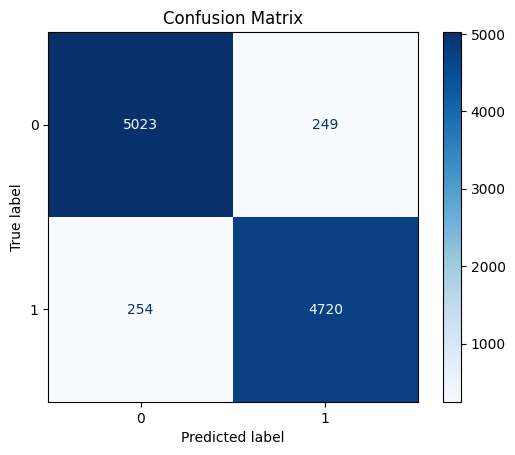

In [12]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Delivery
Run the model on unlabeled test set for delivery

In [15]:
# let's run the model on the test set
# Read data into Pandas dataframe and display first rows
data = pd.read_csv('testing_data_lowercase_nolabels.csv', sep="\t", header=None,  names=['label', 'text'])
data = data[['text', 'label']]

X = data["text"]
y = data["label"]

# Clean text
X_clean = X.apply(clean_text)

# vectorize the test data
X_vect = vectorizer.transform(X_clean)

# Test the stacked model
y_pred = stacked_clf.predict(X_vect)

# Save the predictions to a new csv file with X_test and y_pred
output_file = 'G2_testing_data_labeled.csv'
with open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile, delimiter='\t')
    for i in range(len(y_pred)):
        writer.writerow([y_pred[i], X_clean[i]])


## Calculate final score using the real labels
After delivering the project, we got access to the real labels. We can therefore calculate our final score ourselves.

In [8]:
predictions_df = pd.read_csv('G2_testing_data_labeled.csv', sep="\t", header=None,  names=['label', 'text'])
true_labels_df = pd.read_csv('testing_data_lowercase.csv', sep="\t", header=None,  names=['label', 'text'])

# Merge the two dataframes on the unique identifier 'text'
merged_df = pd.merge(predictions_df, true_labels_df, on='text', suffixes=('_pred', '_true'))

# Compare the predicted and true labels
y_pred = merged_df['label_pred']
y_true = merged_df['label_true']

# Calculate and print metrics
accuracy = accuracy_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Accuracy: 0.9113
Mean Squared Error (MSE): 0.0887
R² Score: 0.5653
